In [207]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests
from vortexasdk import CargoTimeSeries, Products, Geographies

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 14})
pd.options.display.max_columns = None

- It's not all rosy. Global crude oil markets are navigating a complex landscape. This is largely due to geopolitical tensions and supply disruptions. There's a noticeable shift in global oil dynamics, with Brazil joining OPEC+ last year and tensions surrounding the petrodollar. 

- Vortexa data shows that... 

- In this notebook we analyse Vortexa's crude oil floating storage data (retrieved using our Python SDK) and its relationship to crude oil prices. Floating storage is directly determined by oil prices and market dynamics; however, it is not known whether floating storage may be predictive of oil prices in the future. In other words, can floating storage be used as a trading signal for crude oil? Here we apply Granger causality analysis on floating storage and price data, and for the first time demonstrate that floating storage may have significant predictive value for spot crude oil prices 2-3 months into the future.

- Fetching and Visualising Data

- Vortexa Global Crude Oil Floating Storage Data

- Continuing from our previous analysis, we will look at the 4 year period ending ono 31 January 2024. This period encapsulates the COVID pandemic, the war between Russia/Ukraine and the war between Israel and Palestine. 

In [208]:
#Defining date range for historical analysis
START_DATE = datetime(2017, 1, 1)
END_DATE = datetime(2024, 3, 31)
DATE_RANGE = pd.date_range(START_DATE, END_DATE)
CRUDE_NEGATIVE_PRICES_DATE = datetime(2020, 4, 20)
#try from 2016
#Floating storage unit (t = metric tonnes, b = barrels)
UNIT = 't'

We use the CargoTimeSeries endpoint to download floating storage data from Vortexa. The function below makes an API query to retrieve the time series of global crude floating storage. The only filters set in this query are the required start and end time, the activity (set to storing_state for floating storage), and the product (set to Crude/Condensates; similar results are obtained if only Crude is selected, as Condensate floating storage volumes are low). The frequency of the time series is set to daily (the most granular available), and unit to metric tonnes (t; for barrels use b). Importantly, intra_movements is set to all so that intra-country movements are included in the aggregation. By default, this parameter includes all intra-country movements. I have specified it here for transparency. Finally, we do not set filter_storage_locations so that the query will return the total amount of crude stored globally.

In [209]:
def fetch_global_crude_floating_storage_timeseries(start_date, end_date, unit='t'):
    
    # Find Crude/Condensates ID, ensuring its uniqueness
    crude_and_condensates = [p.id for p in Products().search('crude').to_list() if p.name=='Crude/Condensates']
    assert len(crude_and_condensates) == 1
    
    # make Vortexa API query
    # NB: disable_geographic_exclusion_rules is set to True to include intra-movements
    df_fs = CargoTimeSeries().search(timeseries_frequency='day',
                                     timeseries_unit=unit,
                                     intra_movements='all',
                                     filter_products=crude_and_condensates,
                                     filter_activity="storing_state",
                                     filter_time_min=start_date,
                                     filter_time_max=end_date).to_df()

    # rename columns
    df_fs = df_fs.rename(columns={'key': 'date',
                                  'value': unit,
                                  'count': 'number_of_cargo_movements'})
    
    # remove time zone from timestamp
    df_fs['date'] = pd.to_datetime(df_fs['date']).dt.tz_localize(None)

    #define the date crude oil prices went negative
    negative_price_date = pd.to_datetime("2020-04-20")

    # Remove the negative price date from floating storage dataset
    df_fs = df_fs[df_fs['date'] != negative_price_date]
    
    return df_fs

The function above makes the API query and returns a Pandas DataFrame with the time series data. Vessels in floating storage are considered to be in cargo movements, and CargoTimeSeries() will return a count of cargo movements satisfying the filters and their total volume. When the function is run, the SDK prints some log messages confirming the parameters used in the query.

In [185]:
df_fs = fetch_global_crude_floating_storage_timeseries(START_DATE, END_DATE, UNIT)
df_fs

,date,number_of_cargo_movements,t
0,2017-01-01,165,13246916
1,2017-01-02,167,13579238
2,2017-01-03,182,14405097
3,2017-01-04,177,14528908
4,2017-01-05,183,14380180
...,...,...,...
2642,2024-03-27,141,10305589
2643,2024-03-28,128,10547069
2644,2024-03-29,130,10837719
2645,2024-03-30,142,11829661


The returned dataframe contains the dates spanning the requested rang (2017 to 2025), the quantity in the requested unit (tonnes), and the number of cargo movements included in the aggregation. We now create a Pandas Series to hold the floating storage quantity in kilotonnes (kt) and plot this data:

Text(0, 0.5, 'Floating Storage (t)')

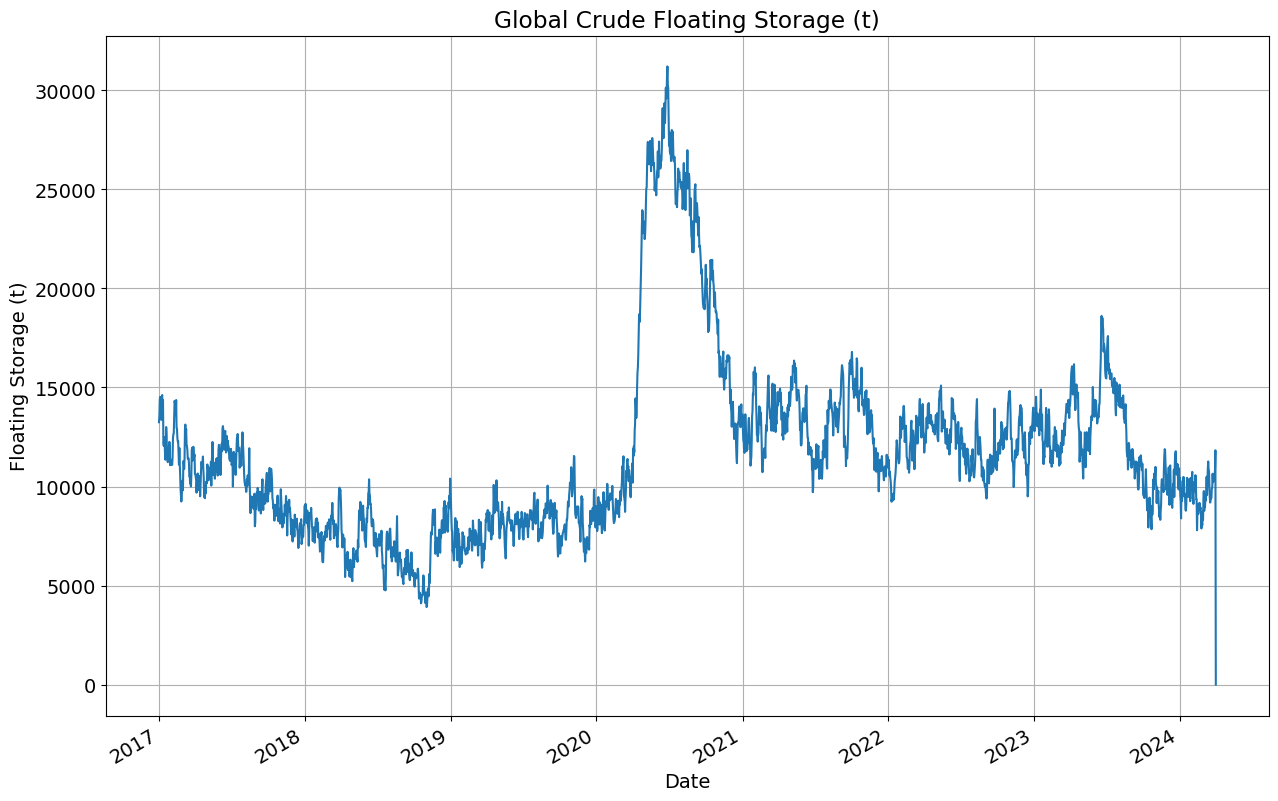

In [186]:
floating_storage = df_fs.set_index('date')[UNIT] / 1000
floating_storage.plot(title='Global Crude Floating Storage (t)', grid=True)
plt.xlabel('Date')
plt.ylabel('Floating Storage (t)')

The graph shows that global floating storage levels remained steady between 2021 and 2023, before peaking in mid 2023 at approximately 18500t. Since then, it has seen a steady decline with a trough at approximately 5000t seen in late 2024. We will now see how the crude oil prices were behaving during this period. REFINE

EIA crude oil prices
The US Energy Information Administration (EIA) reports daily spot prices of crude oil and other products on their website. This data is publicly available and we download the Excel file directly into a Pandas DataFrame below. (NB: although the series has daily resolution, the Excel file is updated on a weekly basis. For details see the information in the Regular Weekly Releases box.) ffill is used to fill gaps in the price data, so we can compare the latest price against floating storage.

In [187]:
spot_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
spot_prices = spot_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
negative_price_date = spot_prices[spot_prices.iloc[:, 0] < 0].index
print(negative_price_date)
spot_prices = spot_prices.drop(negative_price_date)
spot_prices

DatetimeIndex(['2020-04-20'], dtype='datetime64[ns]', freq='D')


,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)",Europe Brent Spot Price FOB (Dollars per Barrel)
2017-01-01,53.75,54.96
2017-01-02,53.75,54.96
2017-01-03,52.36,55.05
2017-01-04,53.26,54.57
2017-01-05,53.77,54.99
...,...,...
2024-03-27,82.15,84.94
2024-03-28,83.96,86.17
2024-03-29,83.96,86.17
2024-03-30,83.96,86.17


We open the sheet containing the crude oil spot prices (sheet Data 1) in the DataFrame and see that it contains two series: Cushing, OK WTI Spot Price and Europe Brent Spot Price. WTI (West Texas Intermediate) is the name of a crude oil grade produced in the US, and Brent is a crude grade produced in the North Sea. Both prices are used as international benchmark in oil transactions. This data is plotted below.

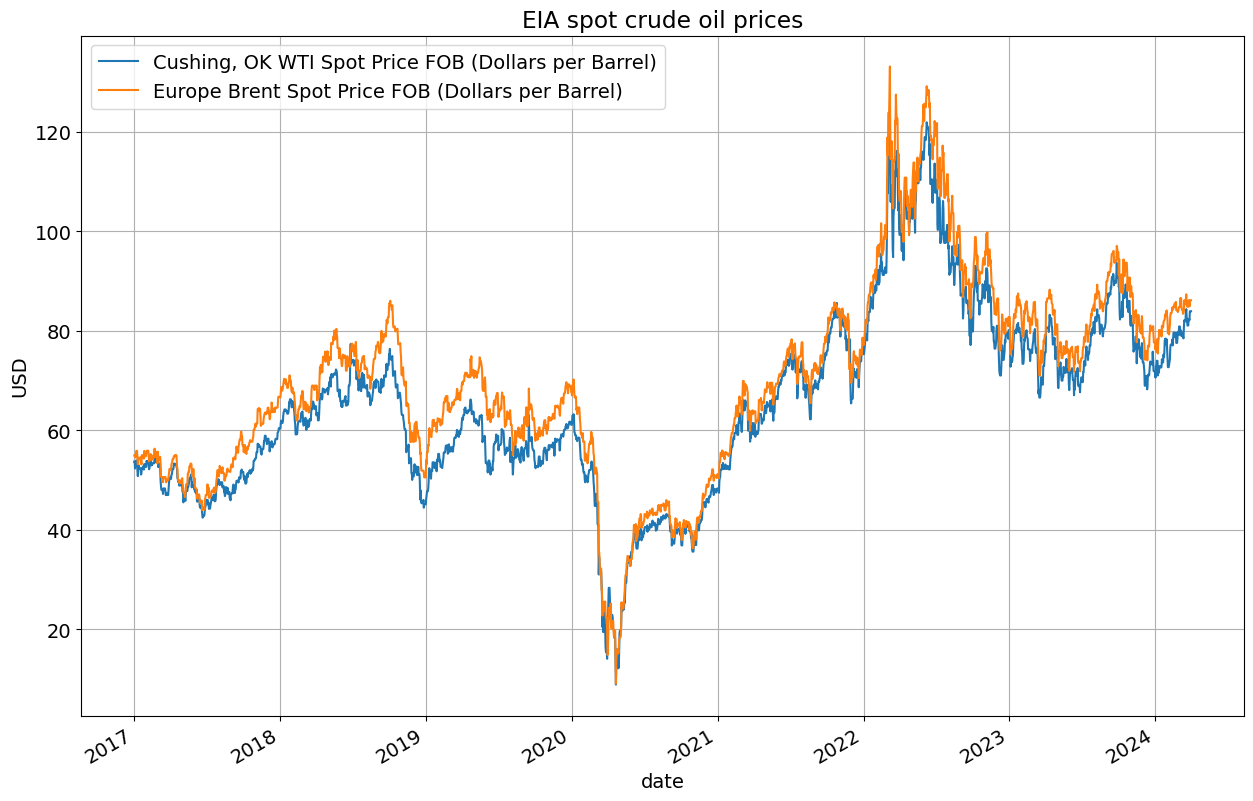

In [188]:
spot_prices.plot(title='EIA spot crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');
#remove dates where crude oil prices are nrgative


We can see that crude prices increased from 2021 to mid 2022, where we saw a sharp rise from roughly $70/barrel to $130/barrel. the start of 2023 saw a return to the baseline of $70-$80 per barrel. We proceed the analysis with Cushing, OK WTI Spot Price, which is kept as a Pandas Series below. We choose WTI because EIA provides both spot and future prices for WTI, but not for Brent.

- The line below extracts the first column of information from the spot prices data frame, excluding Brent prices. 

In [189]:
spot_prices = spot_prices.iloc[:, 0]

Next we retrieve future prices also from EIA. We download the Excel file with the historical price data of NYMEX WTI Future contracts into a DataFrame. 
We remove dates for which crude oil prices were negative in order to exclude outliers (1 data point)

In [190]:
future_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_FUT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
future_prices = future_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
future_prices = future_prices.drop(negative_price_date) #remove dates where crude oil prices are negative
future_prices

,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 2 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 3 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 4 (Dollars per Barrel)"
2017-01-01,53.72,54.66,55.43,56.05
2017-01-02,53.72,54.66,55.43,56.05
2017-01-03,52.33,53.29,54.12,54.81
2017-01-04,53.26,54.22,55.05,55.75
2017-01-05,53.76,54.68,55.49,56.17
...,...,...,...,...
2024-03-27,81.35,80.78,80.19,79.52
2024-03-28,83.17,82.42,81.67,80.89
2024-03-29,83.17,82.42,81.67,80.89
2024-03-30,83.17,82.42,81.67,80.89


The Data 1 sheet in the Excel file contains the prices of four different crude oil future contracts (Contract 1-4). "Contract 1" sets the physical delivery of crude oil in the month following the expiry date of the contract, "Contract 2" sets the delivery 2 months ahead, and so on until "Contract 4" (for details please refer here). A plot of the four future contract prices is shown below.

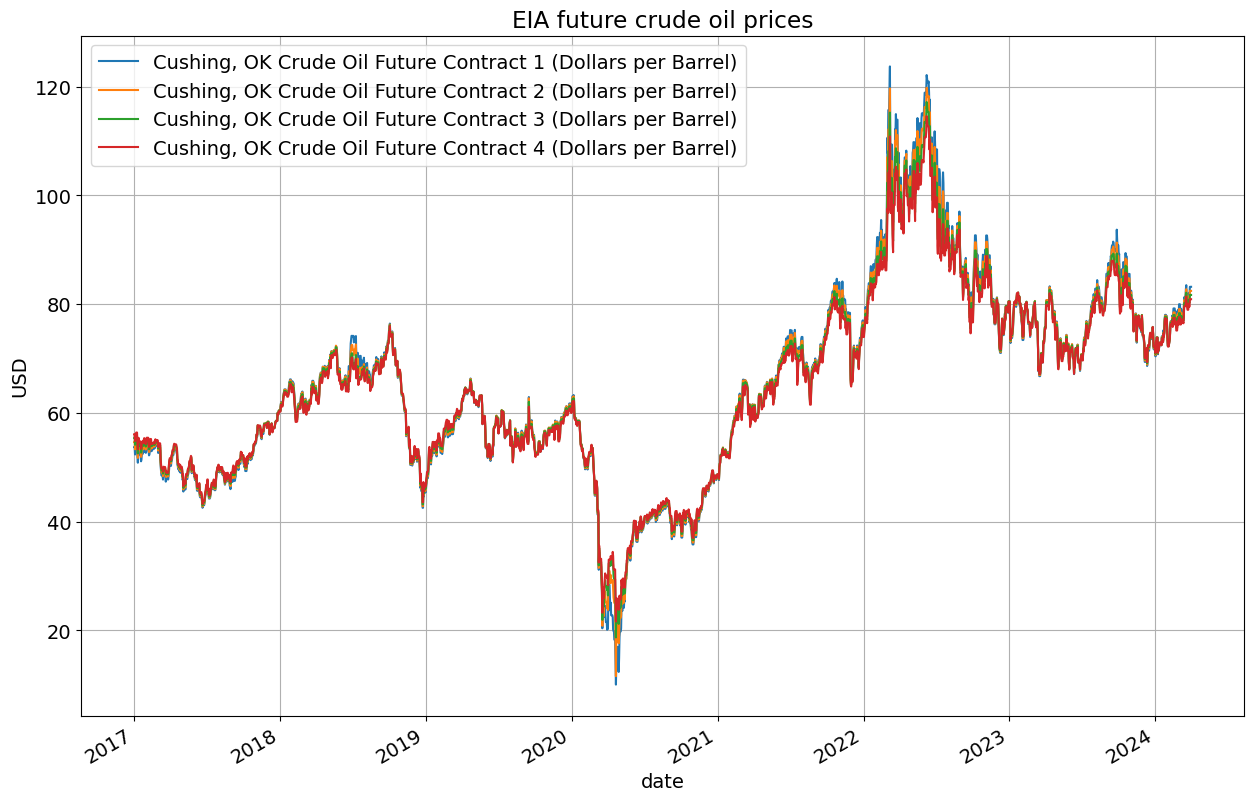

In [191]:
future_prices.plot(title='EIA future crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');

Next we calculate the difference between the future prices and the spot price, also known as calendar spread.

In [192]:
calendar_spread = future_prices - pd.concat([spot_prices] * 4, axis=1).values
calendar_spread

,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 2 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 3 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 4 (Dollars per Barrel)"
2017-01-01,-0.03,0.91,1.68,2.30
2017-01-02,-0.03,0.91,1.68,2.30
2017-01-03,-0.03,0.93,1.76,2.45
2017-01-04,0.00,0.96,1.79,2.49
2017-01-05,-0.01,0.91,1.72,2.40
...,...,...,...,...
2024-03-27,-0.80,-1.37,-1.96,-2.63
2024-03-28,-0.79,-1.54,-2.29,-3.07
2024-03-29,-0.79,-1.54,-2.29,-3.07
2024-03-30,-0.79,-1.54,-2.29,-3.07


Plotting the calendar spreads makes it easy to visualise the periods in which the crude oil market was in contango (spread > 0) and in backwardation (spread < 0).

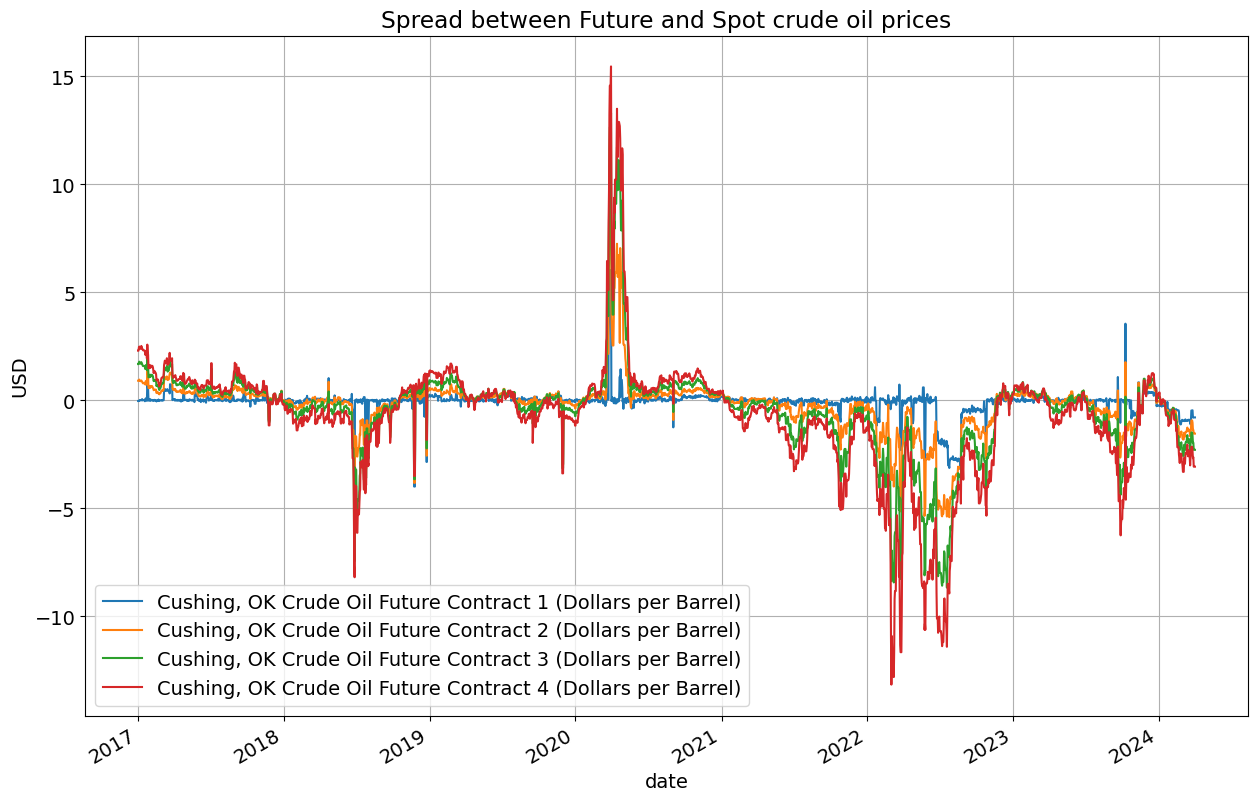

In [193]:
calendar_spread.plot(title='Spread between Future and Spot crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');

We will continue the analysis with "Cushing, OK Crude Oil Future Contract 4" future prices and the corresponding calendar spread, both as Pandas Series.

In [194]:
future_prices = future_prices.iloc[:, 3]
calendar_spread = calendar_spread.iloc[:, 3]

## Cross Correlation Analysis

In [195]:
# Maximum lag in days used for cross-correlation and Granger causality analysis
MAXLAG = 100

We start investigating the relationship between floating storage and prices by doing a simple cross-correlation analysis. For this, we use the pandas.Series.corr function to compute the Pearson correlation coefficient between two time series as we slide one of them in time using the shift function.

In [196]:
def crosscorr(series_x, series_y, lags):
    return pd.Series([series_y.corr(series_x.shift(lag)) for lag in lags], index=lags)

To illustrate how this function works, let's look at the first few lags when we cross-correlated calendar_spread and floating_storage:

In [197]:
crosscorr(calendar_spread, floating_storage, lags=[0, 1])

0    0.121410
1    0.126508
dtype: float64

All values are Pearson correlation coefficients between the two input variables. The index values correspond to the number of days the first variable is shifted "down" relative to the second one, so past values of the first variable are correlated against the present values of the second variable. In the above example, at index 1 "today's" floating storage is correlated with "yesterday's" calendar spread, or equivalently the calendar spread is correlated against floating storage 1 day in the future.
Example?

To help visualise the cross-correlation between the different variables, we define the following function:

In [198]:
def plot_crosscorr(series_x, series_y, maxlag, label_x, label_y):
    lags = np.arange(0, maxlag+1)

    plt.subplot(211)
    xcorr_x_y = crosscorr(series_x, series_y, lags)
    xcorr_x_y.plot(title=f'{label_x} -> {label_y}', grid=True)
    plt.ylabel('correlation coeff.')

    plt.subplot(212)
    xcorr_y_x = crosscorr(series_y, series_x, lags)
    xcorr_y_x.plot(title=f'{label_y} -> {label_x}', grid=True)
    plt.xlabel('lag [days]')
    plt.ylabel('correlation coeff.')

plot_crosscorr splits the cross-correlation results in two: the top plot has the correlation values between series_x and future values of series_y, and the bottom plot the correlation between series_y and future values of series_x. Plotting the cross-correlation between calendar spread and floating storage we obtain:

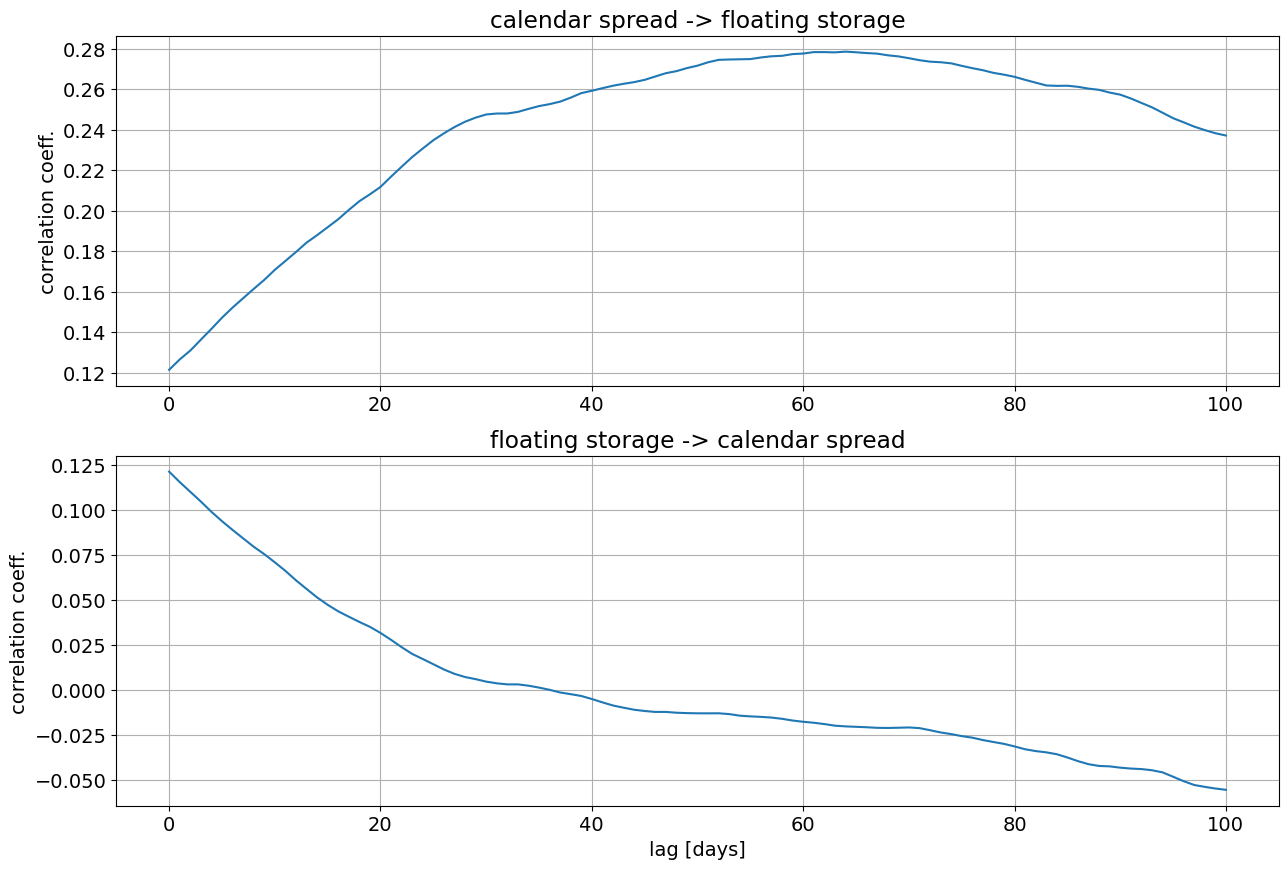

In [199]:
plot_crosscorr(calendar_spread, floating_storage, maxlag=MAXLAG, label_x='calendar spread', label_y='floating storage')

#### WHY DO WE HAVE 2 SUBPLOTS?

- Mathematically, CrossCorr(X,Y) != CrossCorr(Y,X). The correlation between FS and CS at lag t does not equal the correlation between CS and FS at lag t. In other words, the reflection of cross correlation is not symmetrical. 

- By having two plots we will be able to analyse which direction the effect is strongest and which is the leading variable

- Plot 1 checks how well calendar spread leads floating storage at different lags. A high correlation at a positive lag would suggest that changes in calendar spread can predict future storage levels
- Plot 2 checks how well floating storage leads calendar spread at different lags. A high correlation at a positive lag would suggest that changes in floating storage can predict future calendar spread.

- Calendar spread and floating storage are positively correlated over the entire range of lag values examined. The largest value corresponds to the correlation between calendar spread and floating storage around 60 days into the future (top plot).
- SHAF Q: how to interpret the largest value? 

Next we cross-correlate spot prices and floating storage:

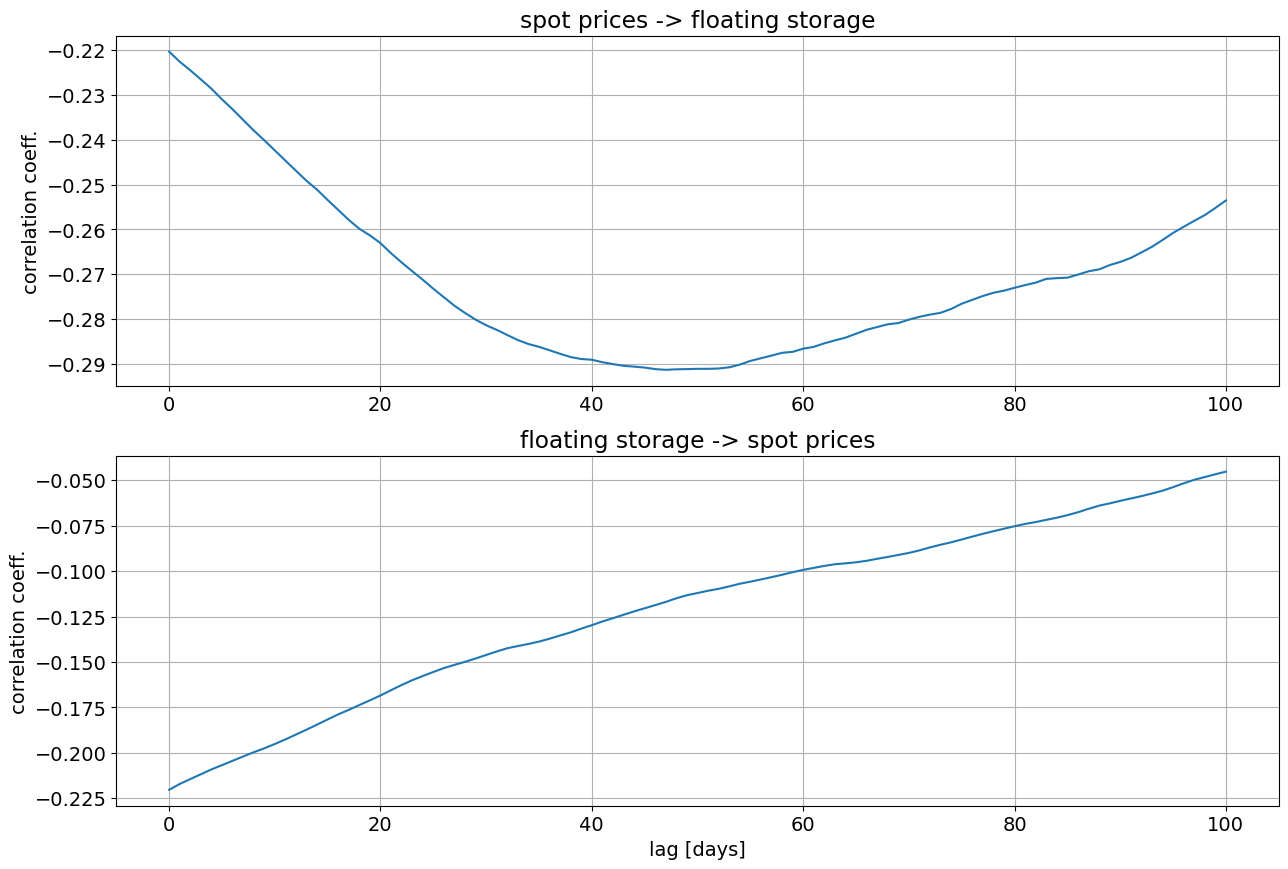

In [200]:
plot_crosscorr(spot_prices, floating_storage, maxlag=MAXLAG, label_x='spot prices', label_y='floating storage')

Spot prices are negatively correlated with floating storage over the entire range of lag values. The largest negative amplitude was found when spot prices were correlated with floating storage ~55 days in the future.

Though useful to detect potential links between variables, cross-correlation is notoriously difficult to interpret. One of the main shortcomings of cross-correlation analysis is that it doesn't disentangle the temporal correlations within each time series (i.e., their autocorrelation) and between time series. If x and y are correlated with zero lag, and future values of y are correlated with the present value of y, then chances are x is also correlated with future values of y even if it does not have any direct causal link with future y.

We use the crosscorr function to calculate and plot the autocorrelation of each time series (alternatively one can use pd.Series.autocorr iteratively).

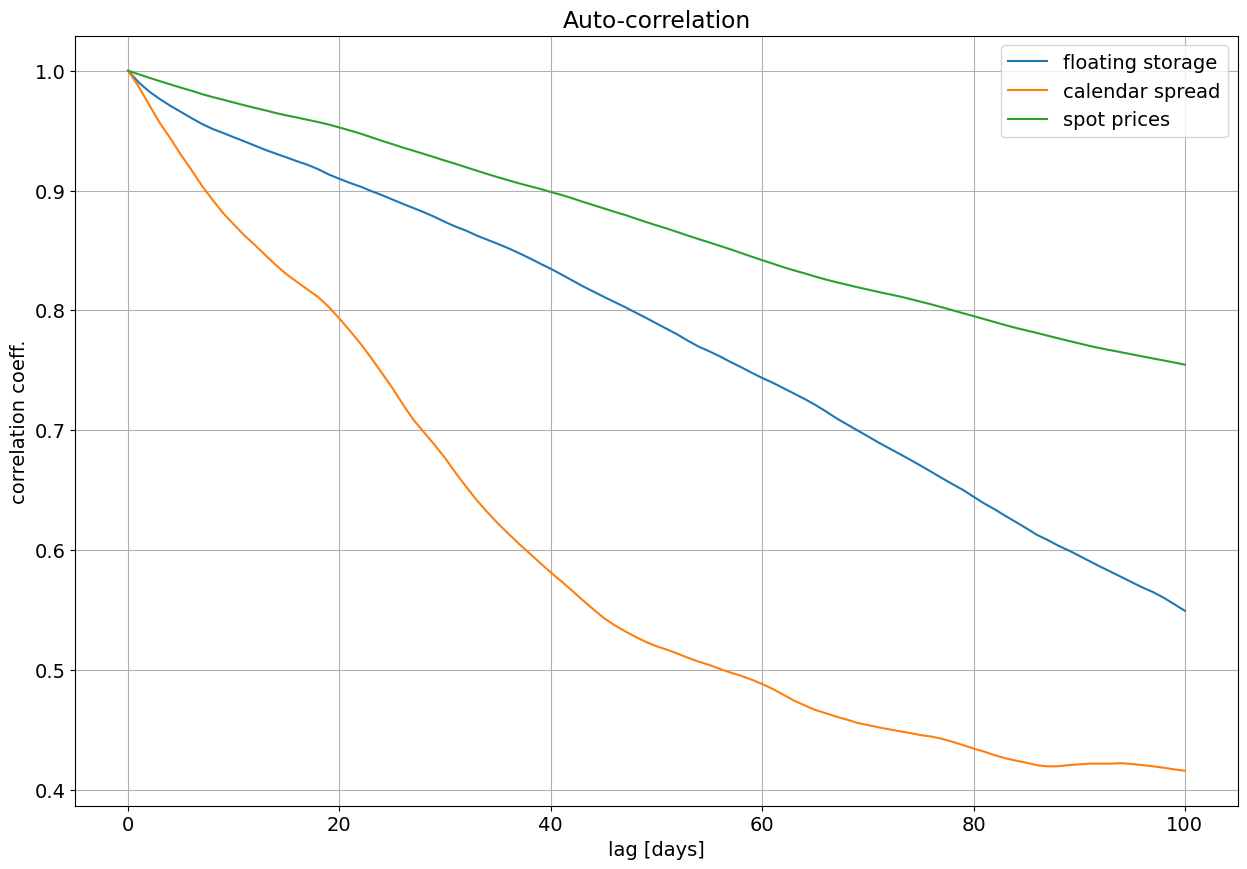

In [201]:
lags = np.arange(0, MAXLAG+1)

crosscorr(floating_storage, floating_storage, lags).plot()
crosscorr(calendar_spread, calendar_spread, lags).plot()
crosscorr(spot_prices, spot_prices, lags).plot()
plt.grid()
plt.title('Auto-correlation')
plt.legend(['floating storage', 'calendar spread', 'spot prices'])
plt.xlabel('lag [days]')
plt.ylabel('correlation coeff.');

As shown above, spot prices have a persistently high positive autocorrelation over time, suggesting a strong tendency for prices to maintain their trajectory within this timeframe. This aligns with market behavior where price trends don't usually reverse in the short-term. 

- Floating storage and calendar spread also display positive autocorrelations, but they look to decay at a faster rate. This means that floating storage levels are quite peristent but fluctuate over medium to long periods. Why is this the case? Storage dynamics depend on supply chain dynamics. Through turbulence in the geopolitical atmosphere, they might not be so stable, relative to spot prices. 

- Calendar spread (difference between near-term and future contracts), in particular, exhibits a sharper decline, indicating that short-term fluctuations play a more significant role in its dynamics. ie. it's highly reactive to market expectations about future supply and demand. 

- The interactions between these 3 variables at this point is not clear but we will investigate further. 

## Granger Causality Analysis

Granger causality is a statistical tool developed specifically to address the "autocorrelation" problem such as the one found above. Granger causality tests whether or not knowledge of x helps predict future values of y beyond what can be predicted by knowing past values of y (thereby controlling for y's autocorrelation). It is commonly used in econometrics and neuroscience to identify potential causal links between multiple time series.

- The Granger Causality test works by running regressions of the dependent variable (e.g. floating storage) on its own past values and on the past values of another variable (e.g. calendar spread). If adding the second variable significantly improves predictions then you can say that the second variable "Granger-causes"/influences the first.

We use the grangercausalitytests implementation provided in the statsmodels package. To check whether calendar_spread Granger-causes floating_storage with a lag of 1 or 2 days, we run:

In [202]:
gct = grangercausalitytests(pd.concat([floating_storage, calendar_spread], axis=1), maxlag=2, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6425  , p=0.0100  , df_denom=2642, df_num=1
ssr based chi2 test:   chi2=6.6500  , p=0.0099  , df=1
likelihood ratio test: chi2=6.6417  , p=0.0100  , df=1
parameter F test:         F=6.6425  , p=0.0100  , df_denom=2642, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.2052  , p=0.0150  , df_denom=2639, df_num=2
ssr based chi2 test:   chi2=8.4263  , p=0.0148  , df=2
likelihood ratio test: chi2=8.4129  , p=0.0149  , df=2
parameter F test:         F=4.2052  , p=0.0150  , df_denom=2639, df_num=2


REITERATE:
grangercausalitytests runs four different tests (ssr based F test, ssr based chi2 test, likelihood ratio test, parameter F test), all of which return similar results. ssr based F test and parameter F test are based on F distribution, and ssr based chi2 test and likelihood ratio test are based on the Chi-squared distribution. For each test, it returns the test statistic, the p-value, and the degrees of freedom. The p-values returned above are all significant (i.e., lower than the conventional threshold of 0.05), suggesting that the second column (calendar_spread) Granger-causes the first column (floating_storage) at both 1- and 2-day lags.

- The lower p values at lower lag (1) suggest that the influence of floating storage on calendar spread is stronger at shorter lags but still present at 2 lags.

The following function plots the Granger causality p-values obtained at each lag and for both directions (x -> y and y -> x). It also plots the confidence level as a visual aid for the easy identification of significant results.

In [203]:
def plot_granger_pvalues(series_x, series_y, maxlag, label_x, label_y, test='ssr_ftest', confidence_level=0.05):
    lags = np.arange(1, maxlag+1)

    plt.subplot(211)
    gct_x_y = grangercausalitytests(pd.concat([series_y, series_x], axis=1), maxlag=maxlag, verbose=False)
    pvalue_x_y = pd.Series([gct_x_y[lag][0][test][1] for lag in lags], index=lags)
    pvalue_x_y.plot(title=f'{label_x} -> {label_y}', grid=True)
    plt.plot((0, maxlag),(confidence_level, confidence_level),'--r')
    plt.ylabel('p-value')

    plt.subplot(212)
    gct_y_x = grangercausalitytests(pd.concat([series_x, series_y], axis=1), maxlag=maxlag, verbose=False)
    pvalue_y_x = pd.Series([gct_y_x[lag][0][test][1] for lag in lags], index=lags)
    pvalue_y_x.plot(title=f'{label_y} -> {label_x}', grid=True)
    plt.plot((0, maxlag),(confidence_level, confidence_level),'--r')
    plt.xlabel('lag [days]')
    plt.ylabel('p-value')


We now test for Granger causality between calendar spread and floating storage:

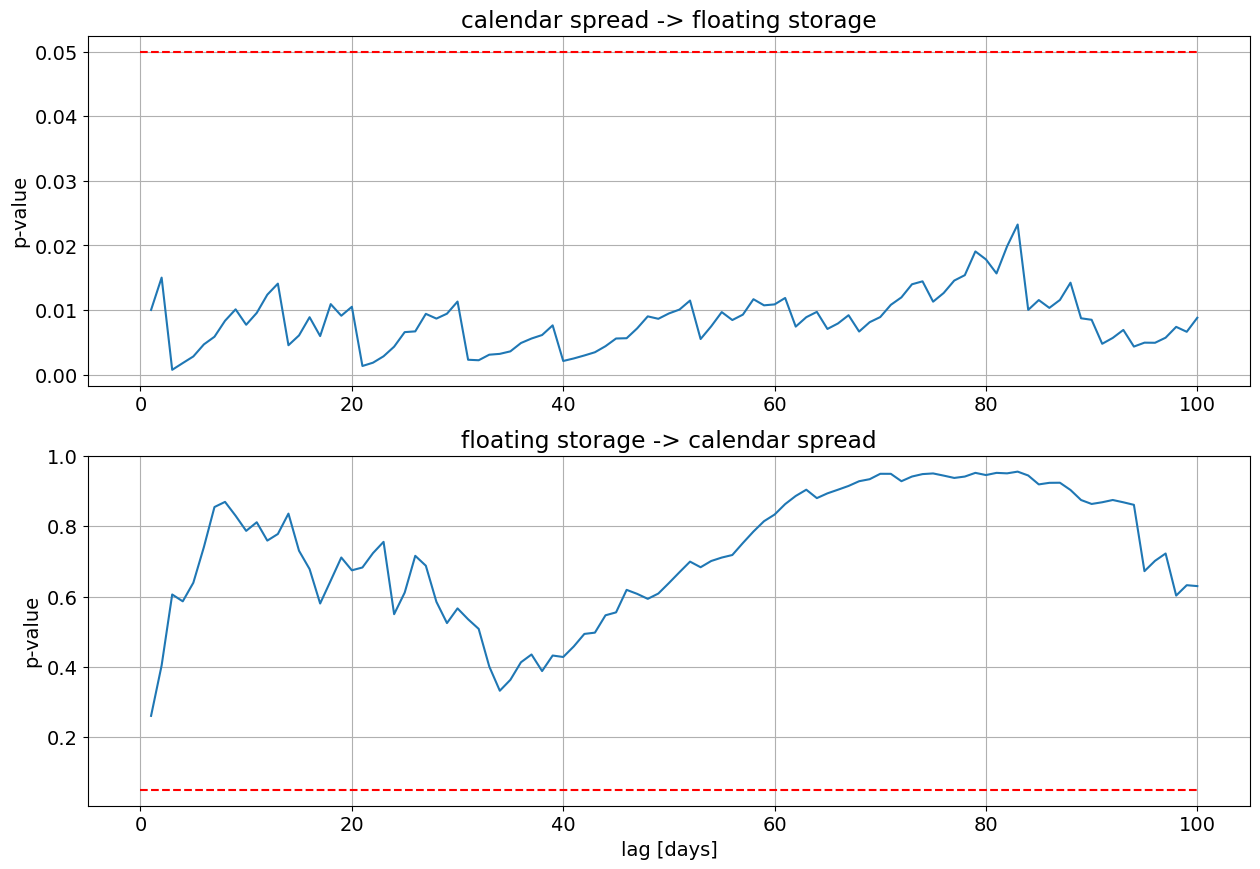

In [204]:
plot_granger_pvalues(calendar_spread, floating_storage, maxlag=MAXLAG, label_x='calendar spread', label_y='floating storage')

The blue lines indicate the p-values of the Granger causality tests, and to identify the significant results we need to look where the p-values dip below the threshold of significance (dashed red lines, set at the conventional threshold of 0.05), meaning that one variable causes the other at that specific lag. CAUSATION OF DIP - OIL PRICES GOING NEGATIVE? 

## Top Plot 
- The p-values are below 0.05 for short-term lags (1-10 days) and also drop near 20-30 days.
- This suggests that calendar spreads Granger-cause floating storage, meaning changes in market structure (contango/backwardation) help predict future shifts in storage behavior. Usually when market calendar spread goes into contango, traders have an incentive to store crude oil and sell it at a higher price later. 

## Bottom Plot
- The majority of the p-values stay above 0.05 which means that there's no strong evidence to suggest that floating storage significantly predicts calendar spreads. 

To conclude, suppliers might react more to calendar spread when contango influences them to store crude oil to sell at higher prices later. So, storage decisions are a response to price signals rather than a primary driver of price spreads. 

We now test for Granger causality between calendar spread and floating storage:

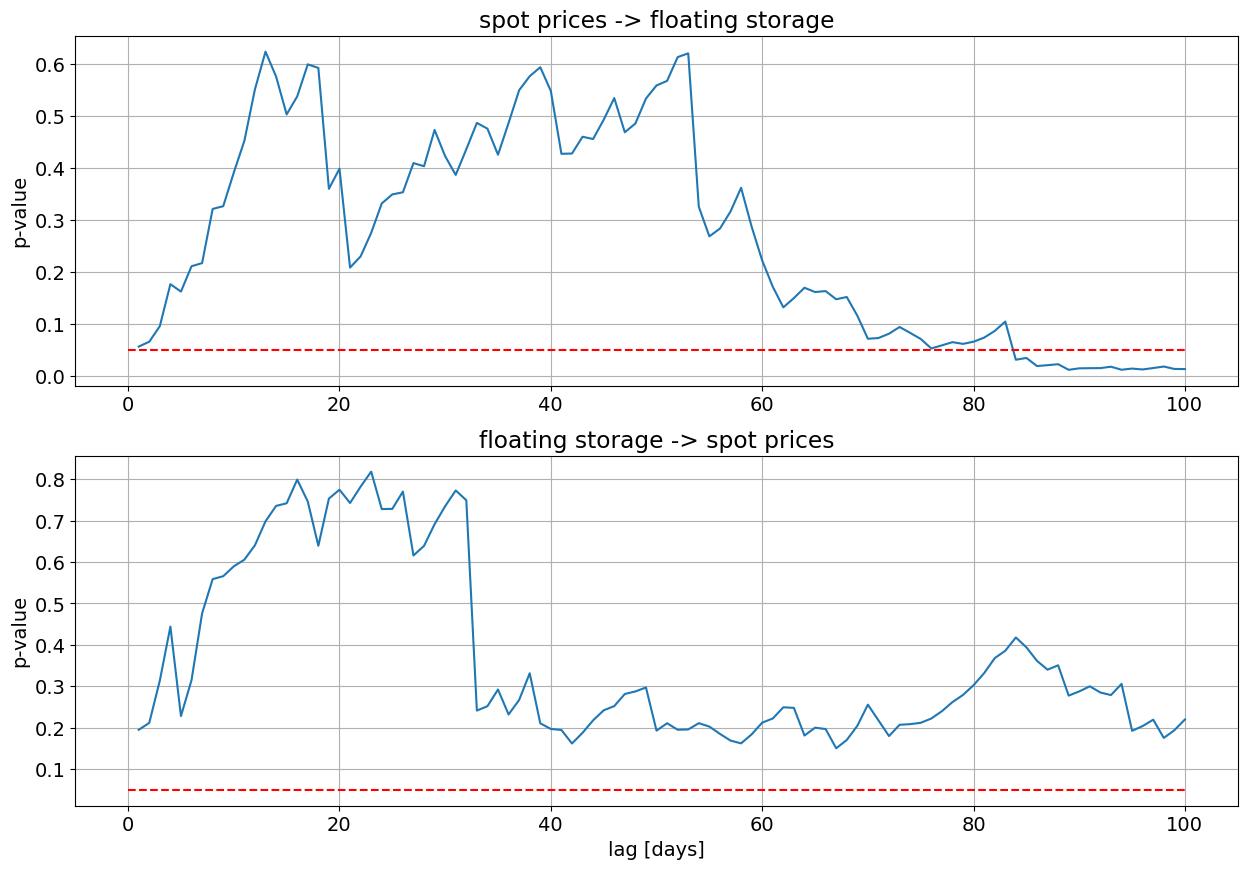

In [205]:
plot_granger_pvalues(spot_prices, floating_storage, maxlag=MAXLAG, label_x='spot prices', label_y='floating storage')

The p values in the top plot are at very short lags (0-5 days) suggesting that spot prices Granger-cause floating storage levels in the very short term. However, beyond this, p values increase significantly, meaning that the predictive power of spot prices weaken over time. Is this intuitive? Would traders immediately increase floating storage levels to wait for higher prices? At longer lags, the relationship is not statistically significant meaning that spot prices wouldn't drive storage decisions over the long run

In the bottom plot, p-values remain consistently well above 0.05 across all lags so there's no strong evidence to suggest floating storage levels predict future spot prices. So, while traders adjust storage levels in response to price movements, the quantity of crude oil in storage doesn't influence crude oil prices significantly (statistically). This might suggest that floating storage is a reactionary market response rather than a leading market response. 

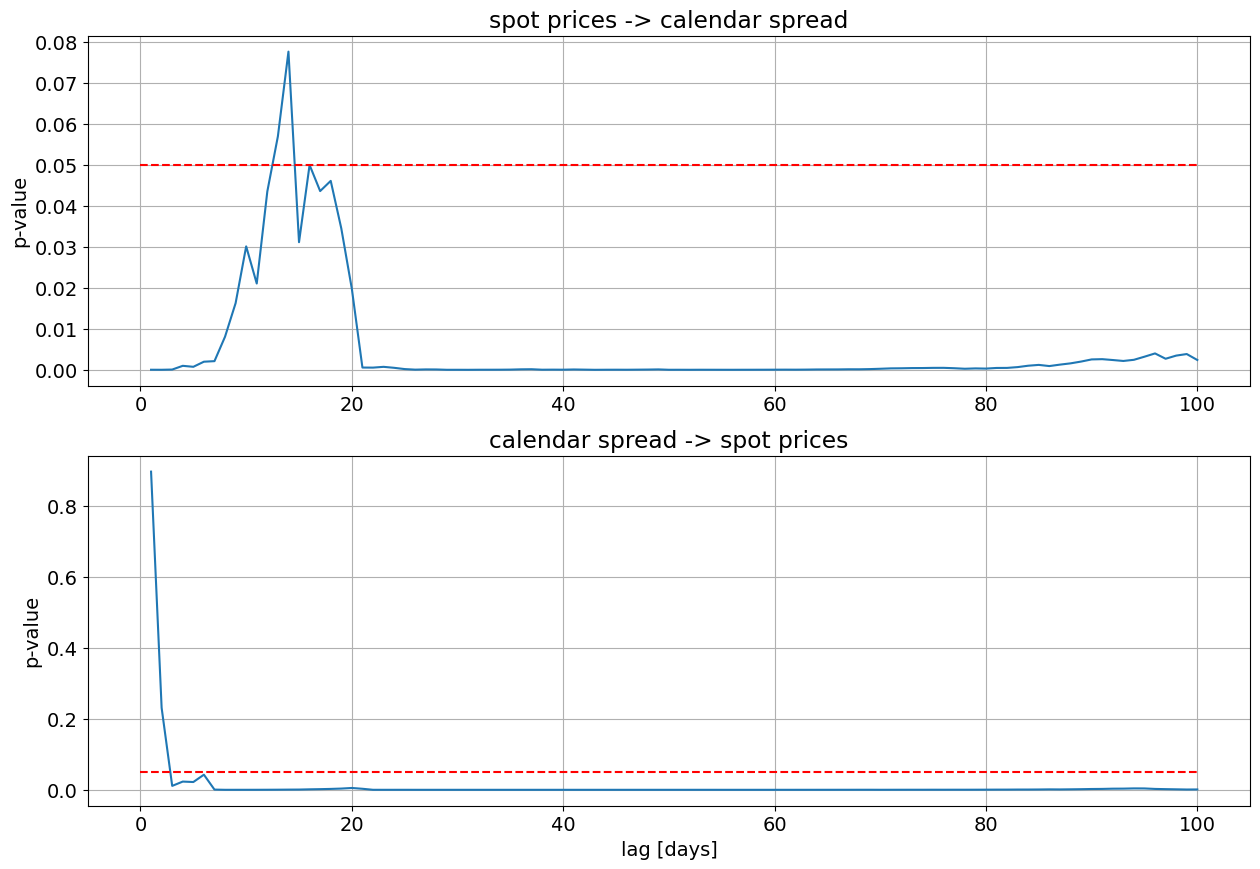

In [206]:
plot_granger_pvalues(spot_prices, calendar_spread, maxlag=MAXLAG, label_x='spot prices', label_y='calendar spread')

In the top plot, p-values are significant for short term lags and lags over 40 days. This suggests that spot prices Granger-cause calendar spreads at these horizons. Interestingly, between 15-30 days, the statistical significance of this relationship (p > 0.05) weakens. An interpretation of this would be that spot prices can influence market expectations causing shifts in calendar spreads. 

In the bottom plot, p-values remain close to 0 across all lags meaning that calendar spreads strongly Granger cause spot prices across all horizons. This would suggest that calendar spreads have a lot of predictive influence over future spot prices, perhaps due to market expectations around supply and demand imbalances. 

## Closing Statements on Granger Causality

- Calendar spreads Granger cause floating storage at short term (1-10 days) and longer term (60+ days) lags. In real world terms, this would suggest that traders respond to contango by increasing levels of floating storage. This would make sense as they're incentivised by the prospect of selling at a future date for higher prices. 
- That being said, floating storage levels do not Granger cause calendar spreads.
- Spot prices Granger cause floating storage at shorter lags (0-5 days) but weaken after 10 days which means traders are more responsive to more immediate fluctuations in spot prices. 
- That being said, floating storage does not predict future spot prices.